In [1]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/uspto/uspto_its_graph_rules_cluster.pkl.gz')

In [2]:
from SynTemp.SynMØD.naive_cluster import NaiveCluster
node_label_names = ["element", "charge"]
naive_cluster = NaiveCluster(node_label_names=node_label_names, node_label_default=["*", 0], edge_attribute="order")
its_graph_rules_cluster = naive_cluster.process_rules_clustering(data, rule_column='GraphRules')

In [3]:
its_graph_rules_cluster[0:2]

[{'R-id': 'USPTO_50K_26',
  'ITSGraph': (<networkx.classes.graph.Graph at 0x7f721c9046d0>,
   <networkx.classes.graph.Graph at 0x7f71fb08ab50>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7f71fb09a650>,
   <networkx.classes.graph.Graph at 0x7f71fb09ae90>),
  'naive_cluster': 0,
  'Reaction Type': 'Single Cyclic',
  'Rings': [4]},
 {'R-id': 'USPTO_50K_50',
  'ITSGraph': (<networkx.classes.graph.Graph at 0x7f71fb09b750>,
   <networkx.classes.graph.Graph at 0x7f71fb0ab8d0>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7f71fb0ba790>,
   <networkx.classes.graph.Graph at 0x7f71fb0bafd0>),
  'naive_cluster': 1,
  'Reaction Type': 'Single Cyclic',
  'Rings': [4]}]

In [4]:
import pandas as pd
pd.DataFrame(its_graph_rules_cluster)['Rings'].value_counts()

Rings
[4]                      26348
[]                        1061
[5]                        692
[6]                        297
[3, 5]                     169
[4, 4, 6]                  151
[3]                         67
[4, 4]                      50
[7]                         22
[4, 5, 5, 5, 6, 7, 8]       20
[3, 3]                      14
[5, 6, 7]                    5
[8]                          4
[4, 4, 4]                    2
[3, 3, 3, 4, 4, 5]           2
[3, 4, 5]                    2
[4, 5, 5]                    1
Name: count, dtype: int64

In [2]:
from rdkit import Chem
mol = Chem.MolFromSmiles("C[C@H](O)[C@@H](O)C")

In [3]:
mol.HasProp('_Name')

0

In [4]:
num_chiral_atoms = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

In [6]:
len(num_chiral_atoms)

2

In [1]:
import networkx as nx
from typing import List

def get_cycle_member_rings(G: nx.Graph) -> List[int]:
    """
    Identifies all cycles in the given graph using cycle bases to ensure no overlap and returns a list of the sizes of these cycles (member rings),
    sorted in ascending order.

    Parameters:
    - G (nx.Graph): The NetworkX graph to be analyzed.

    Returns:
    - List[int]: A sorted list of cycle sizes (member rings) found in the graph.
    """
    if not isinstance(G, nx.Graph):
        raise TypeError("Input must be a networkx Graph object.")

    # Find cycle basis for the graph which gives non-overlapping cycles
    cycles = nx.cycle_basis(G)

    # Determine the size of each cycle (member ring)
    member_rings = [len(cycle) for cycle in cycles]

    # Sort the sizes in ascending order
    member_rings.sort()

    return member_rings


In [4]:
get_cycle_member_rings(G)

[3, 3]

In [2]:
import networkx as nx 

G = nx.Graph()
G.add_edges_from([(5, 6), (6, 7), (7, 8), (8, 5), (5, 7)])

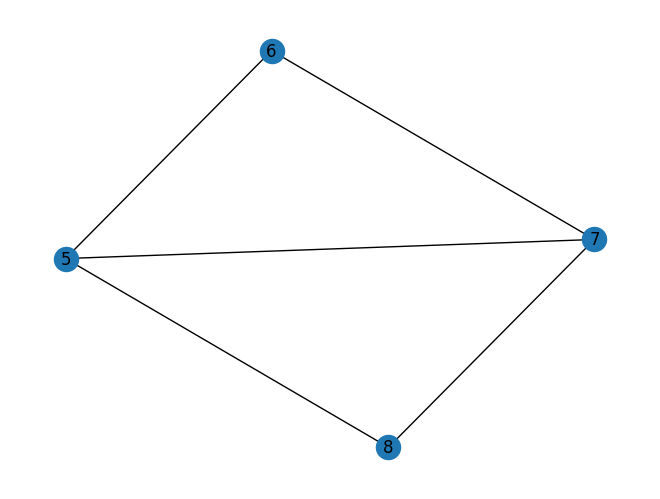

In [3]:
nx.draw(G, with_labels=True)